<a href="https://colab.research.google.com/github/Rencode/fastai/blob/main/man_woman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Man woman deep learning

In [ ]:
!pip install -Uqq fastai

     |████████████████████████████████| 197 kB 30.1 MB/s 
     |████████████████████████████████| 60 kB 7.6 MB/s 


In [ ]:
from fastai.vision.all import *

def is_cat(x): return x[0].isupper()

In [ ]:
path = untar_data(URLs.PETS)/'images'

dls = ImageDataLoaders.from_name_func('.',
    get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat,
    item_tfms=Resize(192))

In [9]:
!pip install httpx
import httpx
import json

def get_images(keywords, max_results=None):
    url = f"https://duckduckgo.com/?va=f&t=hg&q={keywords}&iax=images&ia=images"
    headers = {
        "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
        "accept-language": "en-US,en;q=0.9,hi;q=0.8",
        "cache-control": "max-age=0",
        "sec-ch-ua": "\"Google Chrome\";v=\"113\", \"Chromium\";v=\"113\", \"Not-A.Brand\";v=\"24\"",
        "sec-ch-ua-mobile": "?0",
        "sec-ch-ua-platform": "\"Windows\"",
        "sec-fetch-dest": "document",
        "sec-fetch-mode": "navigate",
        "sec-fetch-site": "same-origin",
        "sec-fetch-user": "?1",
        "sec-gpc": "1",
        "upgrade-insecure-requests": "1",
        "cookie": "p=-2; ah=in-en; l=in-en",
        "Referer": "https://duckduckgo.com/",
        "Referrer-Policy": "origin"
    }

    with httpx.Client() as client:
        response = client.get(url, headers=headers)

    #print("Response status code:", response.status_code)
    resp = response.text

    vqd_index_start = resp.index('vqd="') + 5
    vqd_index_end = resp.index('"', vqd_index_start)
    vqd_bytes = resp[vqd_index_start:vqd_index_end]
    #print(f"vqd_bytes: {vqd_bytes}")

    images_url = f"https://duckduckgo.com/i.js?o=json&q={keywords}&vqd={vqd_bytes}"

    with httpx.Client() as client:
        response = client.get(images_url, headers=headers)

    #print("Response status code:", response.status_code)
    # with open("F://Python//playground//temp.json", "w") as f:
    #     json.dump(response.json(), f)

    response = response.json()
    #response["results"] =
    results = response["results"][:max_results] if max_results else response["results"]
    return [res['image'] for res in results]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB/s eta 0:00:00


In [10]:
from fastdownload import download_url
dest = 'men'
download_url(get_images('men photo')[0], dest)

Path('men')

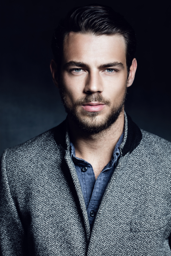

In [12]:
from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [15]:
dest = 'women'
download_url(get_images('women photo')[0], dest)

Path('women')

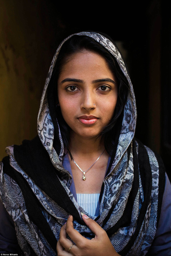

In [16]:
im = Image.open(dest)
im.to_thumb(256,256)

In [ ]:
from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [17]:
searches = 'man','woman'
path = Path('women_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=get_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=get_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=get_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [18]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

In [19]:
len(Path('women_or_not/woman').ls())

282

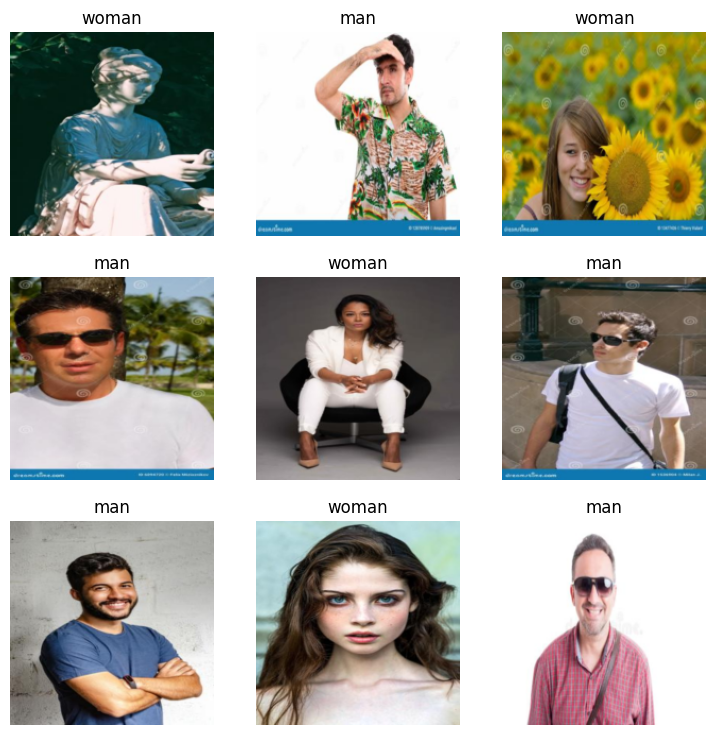

In [22]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch()

In [23]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.986307,0.522875,0.192661,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.456476,0.407639,0.137615,00:02
1,0.291419,0.427104,0.137615,00:02
2,0.189488,0.435570,0.137615,00:02


In [24]:
learn.export('model.pkl')